## Budget Optimization, ROI & Visualising Attribution Weights


This notebook contains the below things - 

1. Visualization of the Attribution weights of the 10 different models we built earlier. 
2. Simulation algorithm for Budget Optimization

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import os

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler

import keras

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
%matplotlib inline

In [3]:
os.chdir(r'N:\ALGORITHMIC MARKETING\Assignment3\criteo_attribution_dataset')

In [4]:
DATA_FILE='criteo_attribution_dataset.tsv.gz'
df_Criteo_Attribution = pd.read_csv(DATA_FILE, sep='\t', compression='gzip')

n_campaigns = 400
df_Criteo_Attribution['day'] = np.floor(df_Criteo_Attribution.timestamp / 86400.).astype(int)

In [5]:
n_campaigns

400

In [6]:
def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext


def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]


def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]
    
def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)


def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext


In [7]:
df_Criteo_Attribution = add_derived_columns(df_Criteo_Attribution)

df_Criteo_Attribution = sample_campaigns(df_Criteo_Attribution, n_campaigns)

df_Criteo_Attribution = filter_journeys_by_length(df_Criteo_Attribution, 2)

df_Criteo_Attribution = balance_conversions(df_Criteo_Attribution)

df_Criteo_Attribution = map_one_hot(df_Criteo_Attribution, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')

df_Criteo_Attribution = map_one_hot(df_Criteo_Attribution, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])



In [8]:
df_Criteo_Attribution.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat6,cat7,cat8,cat9,day,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
643274,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,138937,1795451,29196072,15351056,0,28474333_-1,7.487274e-07,0.003426,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
198026,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,1973606,22644417,9312274,21091111,0,24607497_-1,7.487274e-07,0.163526,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
489422,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,1973606,9180723,29841067,29196072,0,7306395_3063962,1.123091e-06,0.000000,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
305319,4,93907,17686799,0,-1,-1,0,1,-1,-1,...,1973606,2687461,29841067,21091108,0,93907_-1,1.497455e-06,0.101299,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
386692,7,5588915,27491436,0,-1,-1,0,0,-1,-1,...,29196072,21857352,29196072,29196072,0,5588915_-1,2.620546e-06,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Load Attribution Weights

In [9]:
lta = np.loadtxt("lta.txt")
fta = np.loadtxt("fta.txt")
linear_a = np.loadtxt("Linear.txt")
UShape_attr = np.loadtxt("UShape.txt")
TimeDecay_attr = np.loadtxt("TimeDecay.txt")
PositionDecay_attr = np.loadtxt("PositionDecay.txt")
Rev_PosDecay_attr = np.loadtxt("ReversePosDecay.txt")
logistic = np.loadtxt("logistic.txt")
lstm_a = np.loadtxt("lstm_a.txt")

In [10]:
lstm_a

array([0.11830204, 0.13752155, 0.10163243, 0.09873234, 0.11889754,
       0.18202638, 0.14509301, 0.13652155, 0.16118694, 0.09033062,
       0.13439899, 0.12018774, 0.1220181 , 0.12190319, 0.07738397,
       0.11409108, 0.18018038, 0.13950106, 0.13023732, 0.11072992,
       0.17427963, 0.10736781, 0.16917543, 0.15716452, 0.15306322,
       0.12815349, 0.12556003, 0.10004767, 0.15467245, 0.16671813,
       0.14089554, 0.12327826, 0.12880866, 0.13242188, 0.10505067,
       0.1534866 , 0.11167045, 0.14465105, 0.11721619, 0.16500373,
       0.10183122, 0.0937811 , 0.17255257, 0.12568521, 0.15422341,
       0.0784588 , 0.1108971 , 0.14734247, 0.10430076, 0.11080751,
       0.1562435 , 0.15107684, 0.07681396, 0.15507202, 0.11311948,
       0.13924794, 0.14701353, 0.12859074, 0.15038427, 0.1235985 ,
       0.11291868, 0.1353068 , 0.14829289, 0.12385381, 0.11977447,
       0.14274313, 0.13318001, 0.08351962, 0.1175819 , 0.14230094,
       0.11202651, 0.16997758, 0.14681442, 0.11086887, 0.14494

### Comparison of Different Models

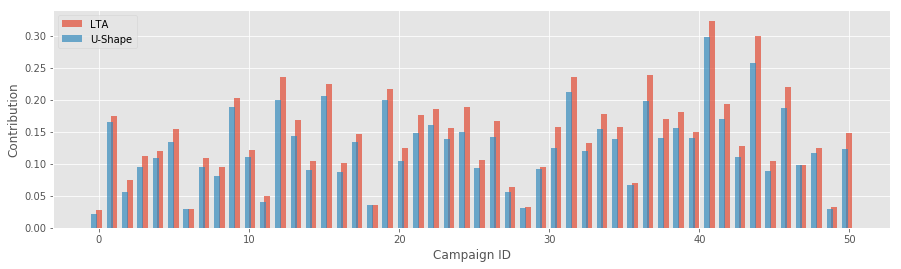

In [11]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(300, 350)

#ratio = max(lta[campaign_idx]) / max(UShape_attr[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, UShape_attr[campaign_idx], width=0.4, alpha=0.7, label='U-Shape' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

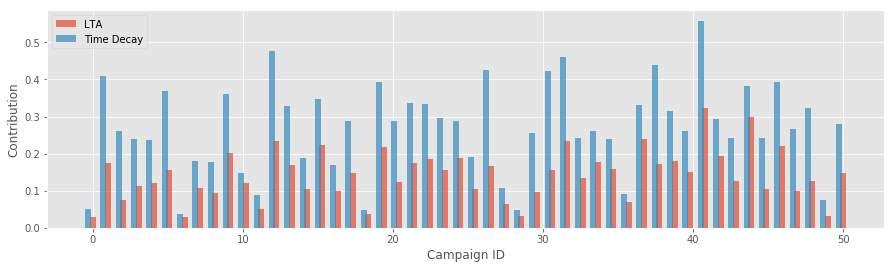

In [12]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(300, 350)

#ratio = max(lta[campaign_idx]) / max(UShape_attr[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, TimeDecay_attr[campaign_idx], width=0.4, alpha=0.7, label='Time Decay' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

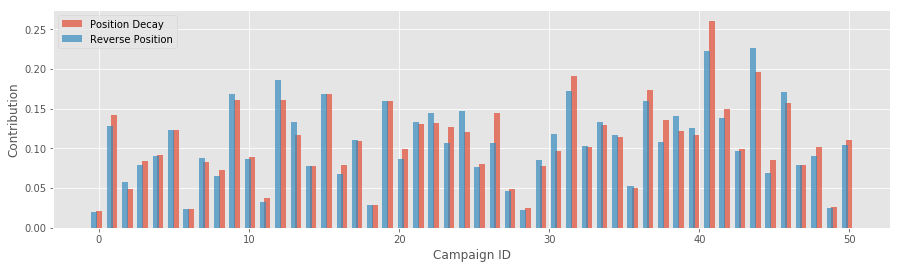

In [13]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(300, 350)

#ratio = max(lta[campaign_idx]) / max(UShape_attr[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), PositionDecay_attr[campaign_idx], width=0.4, alpha=0.7, label='Position Decay' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, Rev_PosDecay_attr[campaign_idx], width=0.4, alpha=0.7, label='Reverse Position' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

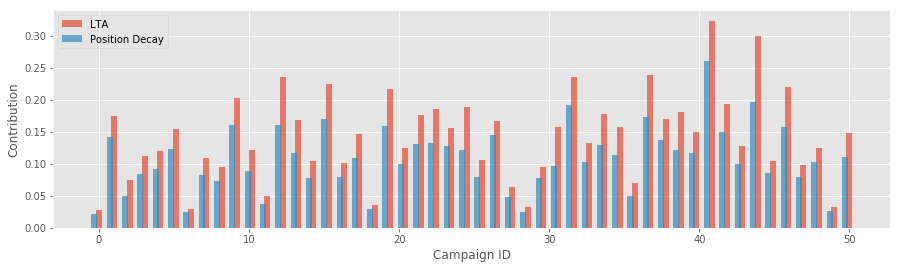

In [14]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(300, 350)

#ratio = max(lta[campaign_idx]) / max(UShape_attr[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, PositionDecay_attr[campaign_idx], width=0.4, alpha=0.7, label='Position Decay' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

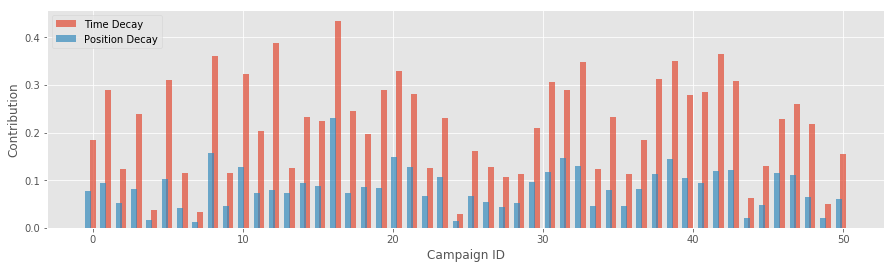

In [16]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(200, 250)

ratio = max(TimeDecay_attr[campaign_idx]) / max(PositionDecay_attr[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), TimeDecay_attr[campaign_idx], width=0.4, alpha=0.7, label='Time Decay' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, PositionDecay_attr[campaign_idx], width=0.4, alpha=0.7, label='Position Decay' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

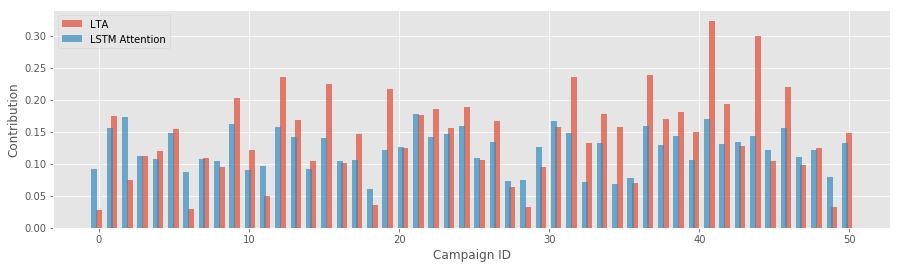

In [17]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(300, 350)

ratio = max(logistic[campaign_idx]) / max(lstm_a[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, lstm_a[campaign_idx], width=0.4, alpha=0.7, label='LSTM Attention' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

#### Line Plots 

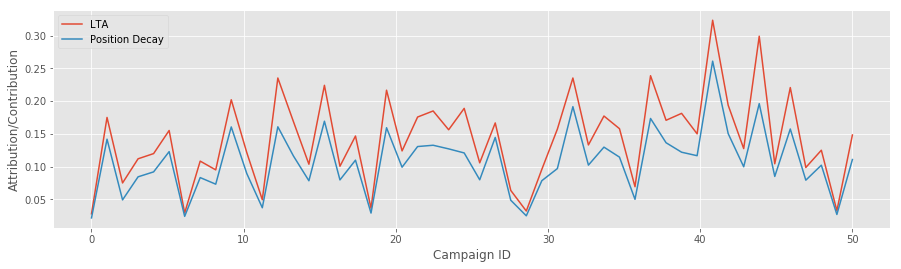

In [18]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(300, 350)

#ratio = max(lta[campaign_idx]) / max(UShape_attr[campaign_idx])
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], label='LTA' )
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), PositionDecay_attr[campaign_idx], label='Position Decay' )
plt.xlabel('Campaign ID')
plt.ylabel('Attribution/Contribution')
plt.legend(loc='upper left')
plt.show()

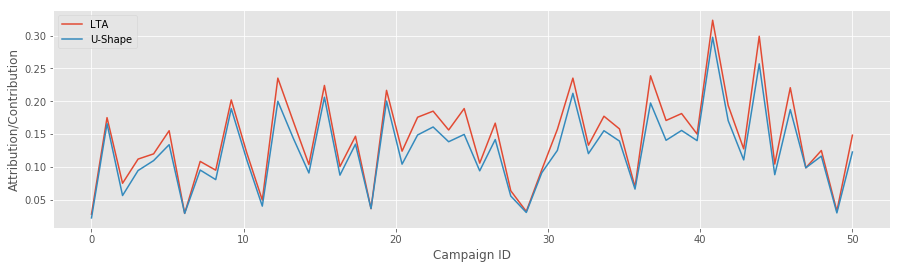

In [19]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(300, 350)

plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), fta[campaign_idx], label='LTA' )
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), UShape_attr[campaign_idx], label='U-Shape' )
plt.xlabel('Campaign ID')
plt.ylabel('Attribution/Contribution')
plt.legend(loc='upper left')
plt.show()

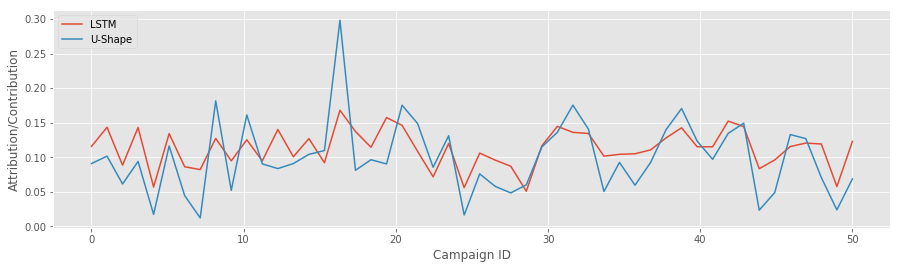

In [20]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(200, 250)

plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), lstm_a[campaign_idx], label='LSTM' )
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), UShape_attr[campaign_idx], label='U-Shape' )
#plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Attribution/Contribution')
plt.legend(loc='upper left')
plt.show()

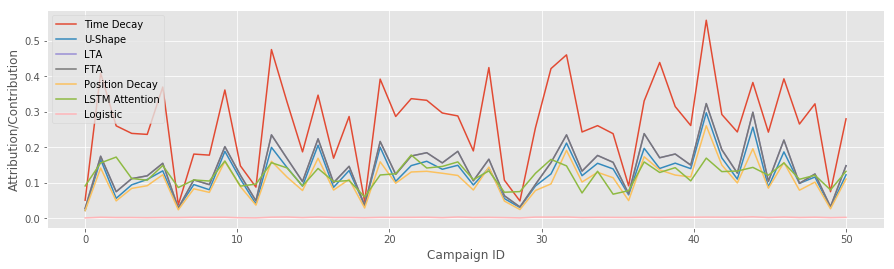

In [21]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(300, 350)

plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), TimeDecay_attr[campaign_idx], label='Time Decay' )
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), UShape_attr[campaign_idx], label='U-Shape' )
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], label='LTA' )
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), fta[campaign_idx], label='FTA' )
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), PositionDecay_attr[campaign_idx], label='Position Decay' )
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), lstm_a[campaign_idx], label='LSTM Attention' )
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), logistic[campaign_idx], label='Logistic' )
plt.xlabel('Campaign ID')
plt.ylabel('Attribution/Contribution')
plt.legend(loc='upper left')
plt.show()

In [22]:
df_Criteo_Attribution.shape

(679215, 28)

## Budget Optimization & Return On Investment


The campaign simulation idea can be outlined as follows:

At the beginning of the process, we distribute a limited budget across the campaigns according to the attribution weights.
We replay the available historical events (ordered by their timestamps) and decrement the budgets accordingly.
Once a campaign runs out of money, we stop to replay the remaining events associated with it and somehow estimate the probabilities of conversion for all journeys affected by this campaign’s suppression.
Finally, we count the total number of conversions and estimate ROI. If none of the campaigns in a converted journey runs out of money before the journey ends, this conversion will be counted explicitly. Otherwise, the estimate of the conversion probability will be used.


We can also tune the parameter(p=pitch). This parameter essentially controls the "pitch" of the budget distribution

In [11]:
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

In [12]:
# Key assumption: If one of the campaigns in a journey runs out of budget, 
# then the conversion reward is fully lost for the entire journey
# including both past and future campaigns

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [28]:
pitches = [0.5, 1.0, 1.5, 2, 2.5, 3]
attributions = [lta, fta, linear_a, UShape_attr, TimeDecay_attr, PositionDecay_attr, logistic, lstm_a]
        
for i, pitch in enumerate(pitches):
    print('Pitch of Budget Allocation - ' + str(pitch))
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df_Criteo_Attribution, 10000, attribution**pitch)
        print('{} {} : {}'.format(i, j, reward))

Pitch of Budget Allocation - 0.5
0 0 : 880
0 1 : 880
0 2 : 799
0 3 : 777
0 4 : 1073
0 5 : 832
0 6 : 1083
0 7 : 1265
Pitch of Budget Allocation - 1.0
1 0 : 185
1 1 : 185
1 2 : 162
1 3 : 164
1 4 : 500
1 5 : 162
1 6 : 738
1 7 : 1157
Pitch of Budget Allocation - 1.5
2 0 : 182
2 1 : 182
2 2 : 193
2 3 : 193
2 4 : 174
2 5 : 188
2 6 : 365
2 7 : 902
Pitch of Budget Allocation - 2
3 0 : 207
3 1 : 207
3 2 : 224
3 3 : 227
3 4 : 180
3 5 : 215
3 6 : 179
3 7 : 685
Pitch of Budget Allocation - 2.5
4 0 : 237
4 1 : 237
4 2 : 260
4 3 : 269
4 4 : 211
4 5 : 238
4 6 : 204
4 7 : 388
Pitch of Budget Allocation - 3
5 0 : 299
5 1 : 299
5 2 : 322
5 3 : 322
5 4 : 246
5 5 : 302
5 6 : 221
5 7 : 171


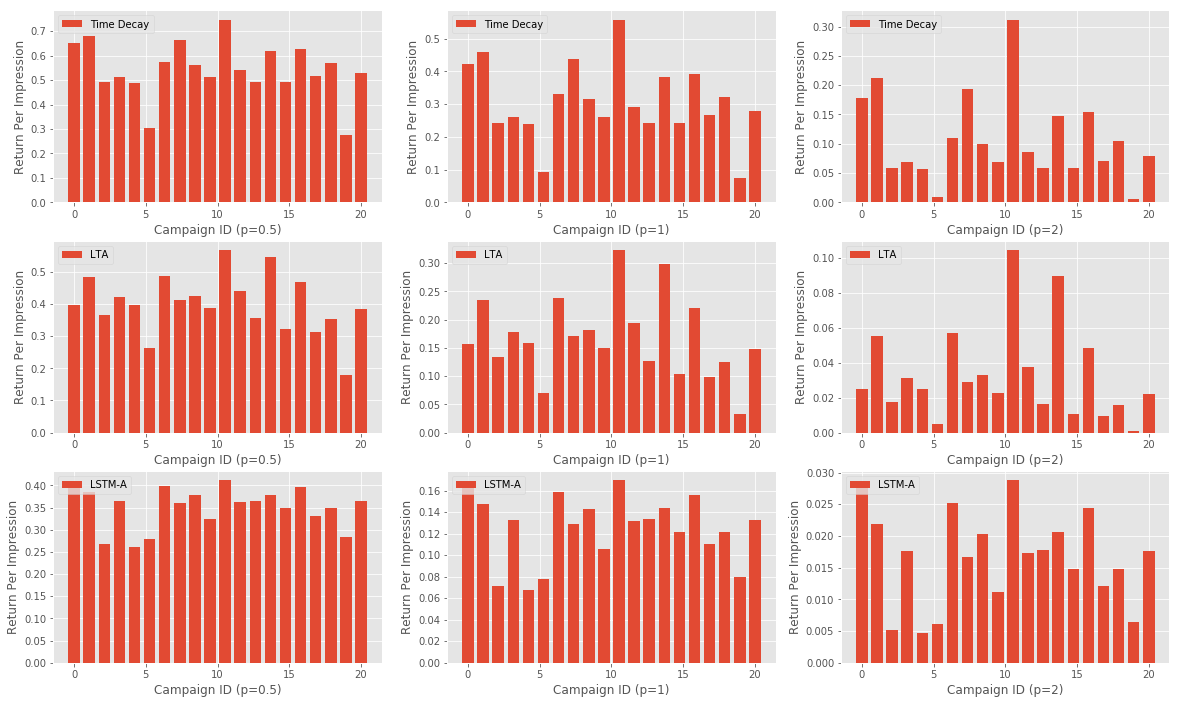

In [29]:
import matplotlib.gridspec as gridspec

fig2 = plt.figure(constrained_layout=False, figsize=(20, 12))
spec2 = gridspec.GridSpec(ncols=3, nrows=3, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0], xlabel='Campaign ID (p=0.5)', ylabel='Return Per Impression')
f2_ax2 = fig2.add_subplot(spec2[0, 1], xlabel='Campaign ID (p=1)', ylabel='Return Per Impression' )
f2_ax3 = fig2.add_subplot(spec2[0, 2], xlabel='Campaign ID (p=2)', ylabel='Return Per Impression')
f2_ax4 = fig2.add_subplot(spec2[1, 0], xlabel='Campaign ID (p=0.5)', ylabel='Return Per Impression')
f2_ax5 = fig2.add_subplot(spec2[1, 1], xlabel='Campaign ID (p=1)', ylabel='Return Per Impression')
f2_ax6 = fig2.add_subplot(spec2[1, 2], xlabel='Campaign ID (p=2)', ylabel='Return Per Impression')
f2_ax7 = fig2.add_subplot(spec2[2, 0], xlabel='Campaign ID (p=0.5)', ylabel='Return Per Impression')
f2_ax8 = fig2.add_subplot(spec2[2, 1], xlabel='Campaign ID (p=1)', ylabel='Return Per Impression')
f2_ax9 = fig2.add_subplot(spec2[2, 2], xlabel='Campaign ID (p=2)', ylabel='Return Per Impression')

campaign_idx = range(330, 350)

f2_ax1.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), TimeDecay_attr[campaign_idx]**0.5, label='Time Decay')
f2_ax1.legend(loc='upper left')
f2_ax2.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), TimeDecay_attr[campaign_idx], label='Time Decay')
f2_ax2.legend(loc='upper left')
f2_ax3.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), TimeDecay_attr[campaign_idx]**2, label='Time Decay')
f2_ax3.legend(loc='upper left')
f2_ax4.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx]**0.5, label='LTA')
f2_ax4.legend(loc='upper left')
f2_ax5.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], label='LTA')
f2_ax5.legend(loc='upper left')
f2_ax6.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx]**2, label='LTA')
f2_ax6.legend(loc='upper left')
f2_ax7.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lstm_a[campaign_idx]**0.5, label='LSTM-A')
f2_ax7.legend(loc='upper left')
f2_ax8.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lstm_a[campaign_idx], label='LSTM-A')
f2_ax8.legend(loc='upper left')
f2_ax9.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lstm_a[campaign_idx]**2, label='LSTM-A')
f2_ax9.legend(loc='upper left')


plt.show()

### Plotting the best models & Running for different values of Pitch


In [14]:
import time 

start = time.time()

pitches = [0, 0.25, 0.5, 0.75]
attributions = [lta, TimeDecay_attr, PositionDecay_attr, Rev_PosDecay_attr, logistic, lstm_a]
        
for i, pitch in enumerate(pitches):
    print('Pitch of Budget Allocation - ' + str(pitch))
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df_Criteo_Attribution, 10000, attribution**pitch)
        print('{} {} : {}'.format(i, j, reward))
        
end = time.time()

Pitch of Budget Allocation - 0
0 0 : 995
0 1 : 995
0 2 : 995
0 3 : 995
0 4 : 995
0 5 : 995
Pitch of Budget Allocation - 0.25
1 0 : 905
1 1 : 970
1 2 : 854
1 3 : 855
1 4 : 860
1 5 : 972
Pitch of Budget Allocation - 0.5
2 0 : 641
2 1 : 835
2 2 : 593
2 3 : 567
2 4 : 759
2 5 : 933
Pitch of Budget Allocation - 0.75
3 0 : 413
3 1 : 605
3 2 : 376
3 3 : 364
3 4 : 594
3 5 : 851


In [15]:
time_taken = end - start
print('Time taken for ROI Budget Simulation for Best models - ', str(time_taken))

Time taken for ROI Budget Simulation for Best models -  5946.649751663208


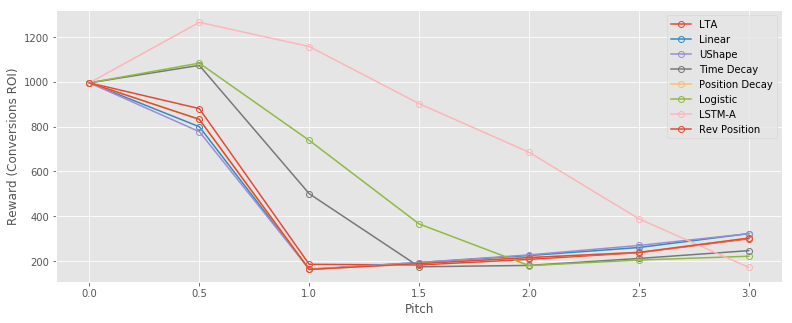

In [24]:
fig = plt.figure(figsize=(13, 5))

campaign_idx = range(0, 7)


ROI_LTA = [995, 880, 185, 182, 207, 237, 299]
ROI_LTA = np.array(ROI_LTA)

ROI_Linear = [995, 799, 162, 193, 224, 260, 322]
ROI_Linear = np.array(ROI_Linear)


ROI_UShape = [995, 777, 164, 193, 227, 269, 322]
ROI_UShape = np.array(ROI_UShape)

ROI_TimeDecay = [995, 1073, 500, 174, 180, 211, 246]
ROI_TimeDecay = np.array(ROI_TimeDecay)

ROI_PosDecay = [995, 832, 162, 188, 215, 238, 302]
ROI_PosDecay = np.array(ROI_PosDecay)

ROI_RevPosDecay = [995, 832, 162, 188, 215, 238, 302]
ROI_RevPosDecay = np.array(ROI_RevPosDecay)

ROI_Logistic = [995, 1083, 738, 365, 179, 204, 221]
ROI_Logistic = np.array(ROI_Logistic)

ROI_LSTM_A = [995, 1265, 1157, 902, 685, 388, 171]
ROI_LSTM_A = np.array(ROI_LSTM_A)

pitch = [0, 0.5, 1, 1.5, 2, 2.5, 3]
pitch = np.array(pitch)


plt.plot(pitch[campaign_idx], ROI_LTA[campaign_idx], label='LTA' , linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")
plt.plot(pitch[campaign_idx], ROI_Linear[campaign_idx], label='Linear' , linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")
plt.plot(pitch[campaign_idx], ROI_UShape[campaign_idx], label='UShape' , linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")
plt.plot(pitch[campaign_idx], ROI_TimeDecay[campaign_idx], label='Time Decay' , linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")
plt.plot(pitch[campaign_idx], ROI_PosDecay[campaign_idx], label='Position Decay' , linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")
plt.plot(pitch[campaign_idx], ROI_Logistic[campaign_idx], label='Logistic' , linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")
plt.plot(pitch[campaign_idx], ROI_LSTM_A[campaign_idx], label='LSTM-A' , linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")
plt.plot(pitch[campaign_idx], ROI_RevPosDecay[campaign_idx], label='Rev Position' , linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")



plt.xlabel('Pitch')
plt.ylabel('Reward (Conversions ROI)')
plt.legend(loc='upper right')
plt.show()

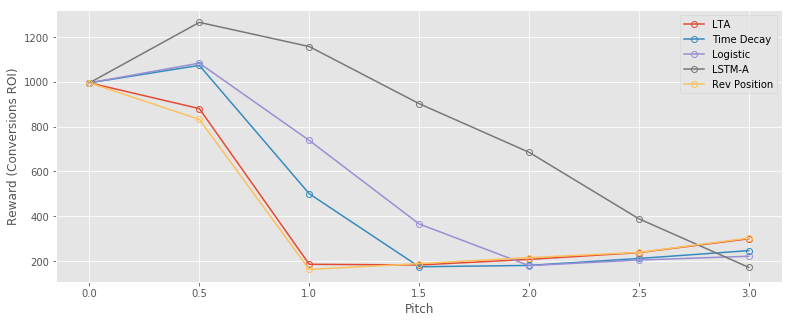

In [25]:
fig = plt.figure(figsize=(13, 5))

campaign_idx = range(0, 7)


ROI_LTA = [995, 880, 185, 182, 207, 237, 299]
ROI_LTA = np.array(ROI_LTA)

ROI_TimeDecay = [995, 1073, 500, 174, 180, 211, 246]
ROI_TimeDecay = np.array(ROI_TimeDecay)

ROI_PosDecay = [995, 832, 162, 188, 215, 238, 302]
ROI_PosDecay = np.array(ROI_PosDecay)

ROI_RevPosDecay = [995, 832, 162, 188, 215, 238, 302]
ROI_RevPosDecay = np.array(ROI_RevPosDecay)

ROI_Logistic = [995, 1083, 738, 365, 179, 204, 221]
ROI_Logistic = np.array(ROI_Logistic)

ROI_LSTM_A = [995, 1265, 1157, 902, 685, 388, 171]
ROI_LSTM_A = np.array(ROI_LSTM_A)

pitch = [0, 0.5, 1, 1.5, 2, 2.5, 3]
pitch = np.array(pitch)


plt.plot(pitch[campaign_idx], ROI_LTA[campaign_idx], label='LTA' , linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")
plt.plot(pitch[campaign_idx], ROI_TimeDecay[campaign_idx], label='Time Decay' , linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")
plt.plot(pitch[campaign_idx], ROI_Logistic[campaign_idx], label='Logistic' , linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")
plt.plot(pitch[campaign_idx], ROI_LSTM_A[campaign_idx], label='LSTM-A' , linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")
plt.plot(pitch[campaign_idx], ROI_RevPosDecay[campaign_idx], label='Rev Position' , linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")




plt.xlabel('Pitch')
plt.ylabel('Reward (Conversions ROI)')
plt.legend(loc='upper right')
plt.show()

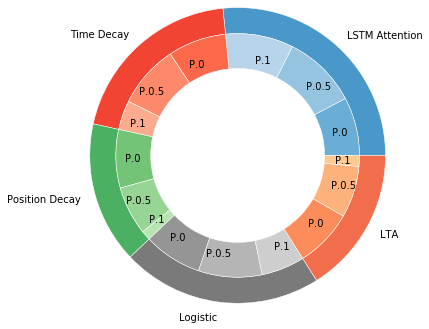

In [27]:
import matplotlib.pyplot as plt
 
# Make data: I have 3 groups and 7 subgroups
group_names=['LSTM Attention', 'Time Decay', 'Position Decay', 'Logistic', 'LTA']
group_size=[3417,2568,1989,2816, 2060]
subgroup_names=['P.0', 'P.0.5', 'P.1', 'P.0', 'P.0.5', 'P.1', 'P.0', 'P.0.5', 'P.1', 
                'P.0', 'P.0.5', 'P.1', 'P.0', 'P.0.5', 'P.1',]
subgroup_size=[995,1265,1157,995, 1073, 500,995, 832, 162, 995, 1083, 738,995, 880, 185]
 
# Create colors
a, b, c, d, e=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Greys, plt.cm.OrRd]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.7, labels=group_names, colors=[a(0.6), b(0.6), c(0.6), d(0.6), e(0.6)] )
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.7-0.3, labels=subgroup_names, labeldistance=0.8, 
                   colors=[a(0.5), a(0.4), a(0.3), b(0.5), b(0.4), b(0.3), c(0.5), c(0.4), c(0.3), d(0.5), d(0.4), d(0.3)
                          , e(0.5), e(0.4), e(0.3)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)
# show it
plt.show()
